# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4a0f22cac0271a4caaafb7ec515a3d2e06ea106ea9cbee60de967a1afa8737b7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [12]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [6]:
def image_to_tensor(img):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [7]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [8]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [9]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

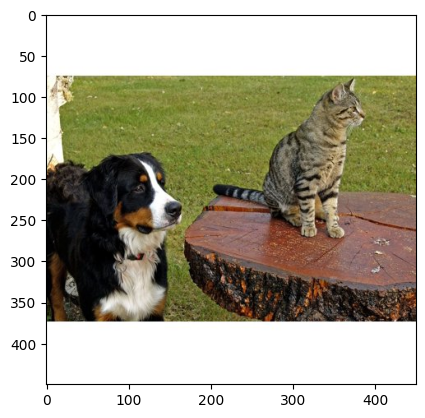

In [14]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [15]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [16]:
inception_v3 = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 145MB/s] 


### **Predykcja**

In [17]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [18]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [19]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [44]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)

    model.eval()

    model.cpu()
    img_tensor = img_tensor.cpu()

    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)

    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

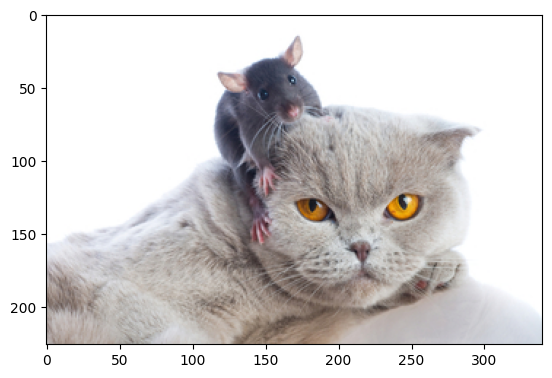

In [21]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [22]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967491
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [23]:
explainer = lime_image.LimeImageExplainer()

In [24]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [25]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

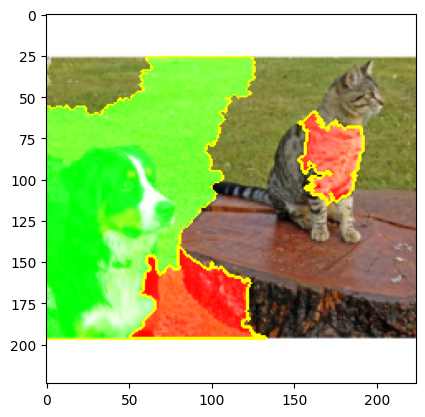

In [26]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

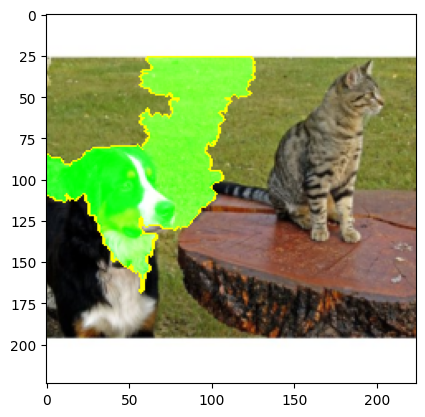

In [27]:
NUM_FEATURES = 3

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

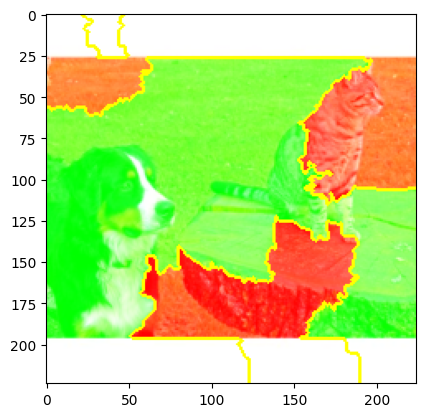

In [28]:
NUM_FEATURES = 40

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
> A superpixel refers to a group of adjacent pixels considered as an interpretable feature in image data analysis.
https://www.sciencedirect.com/topics/computer-science/superpixel

Jest to grupa przylegających pikseli dzielących daną cechę obrazu.
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Nie musi tak być, superpiksel może być grupą wielu pikseli.



Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

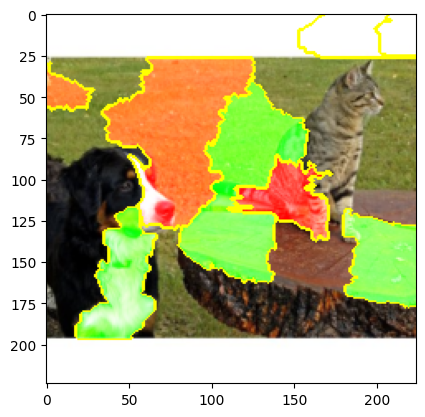

In [29]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

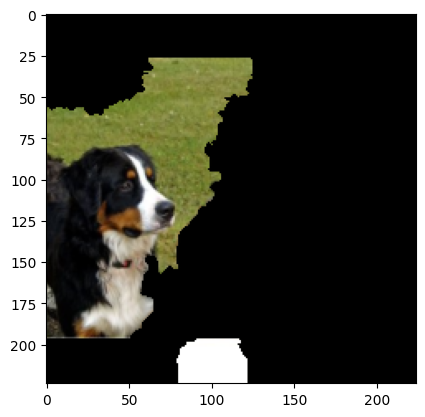

In [30]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

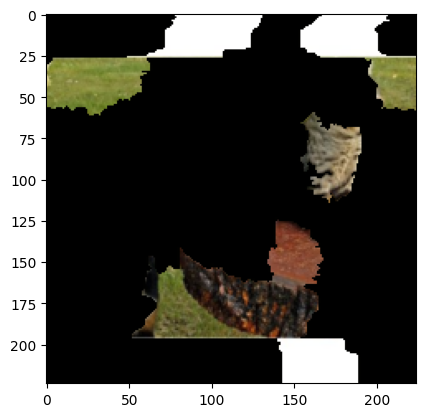

In [31]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [39]:
def image_from_array(img_np):

  img_from_arr = Image.fromarray(img_np)
  img_from_arr.save("temp.png")
  img_pil = get_image("temp.png")

  return img_pil

In [45]:
cropped_image_pil = image_from_array(cropped_image_ndarray)
get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: assault_rifle                  | Probability: 0.487859
Class: groom                          | Probability: 0.348990
Class: cauliflower                    | Probability: 0.032767
Class: rifle                          | Probability: 0.026994
Class: cannon                         | Probability: 0.017658
Class: military_uniform               | Probability: 0.009547
Class: half_track                     | Probability: 0.004984
Class: abaya                          | Probability: 0.004541
Class: revolver                       | Probability: 0.004230
Class: conch                          | Probability: 0.003561
Class: academic_gown                  | Probability: 0.003448
Class: mortarboard                    | Probability: 0.003446
Class: kimono                         | Probability: 0.002726
Class: Scotch_terrier                 | Probability: 0.001922
Class: golfcart                       | Probability: 0.001811


I jak go teraz widzi model

In [46]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

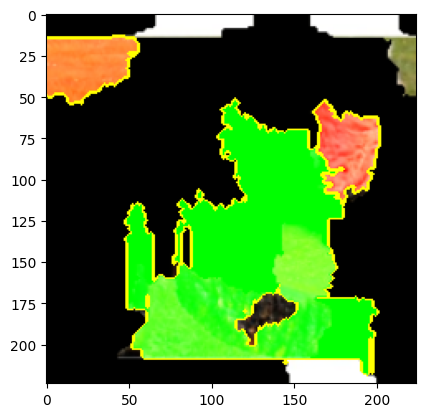

In [47]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [48]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 166MB/s]


In [49]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

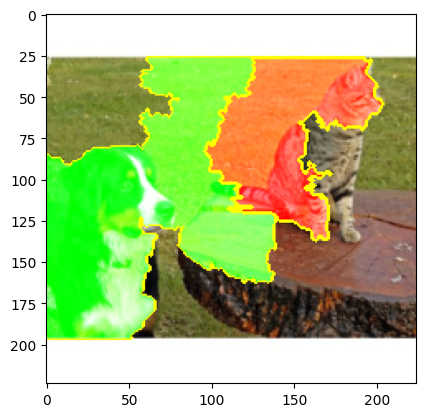

In [51]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [52]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [53]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

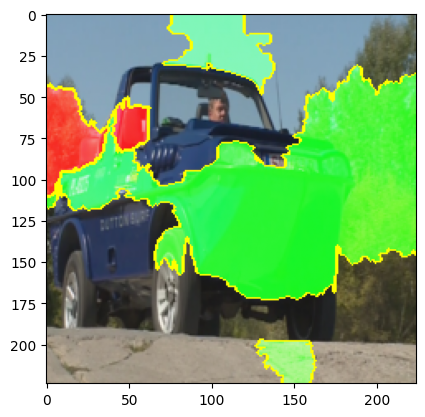

In [54]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [55]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

In [56]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Eurasian_wolf_2.jpg/1024px-Eurasian_wolf_2.jpg -O data/wolf.jpg

--2024-10-16 16:26:32--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Eurasian_wolf_2.jpg/1024px-Eurasian_wolf_2.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147294 (144K) [image/jpeg]
Saving to: ‘data/wolf.jpg’

data/wolf.jpg       100%[===================>] 143.84K  --.-KB/s    in 0.05s   

2024-10-16 16:26:33 (2.82 MB/s) - ‘data/wolf.jpg’ saved [147294/147294]



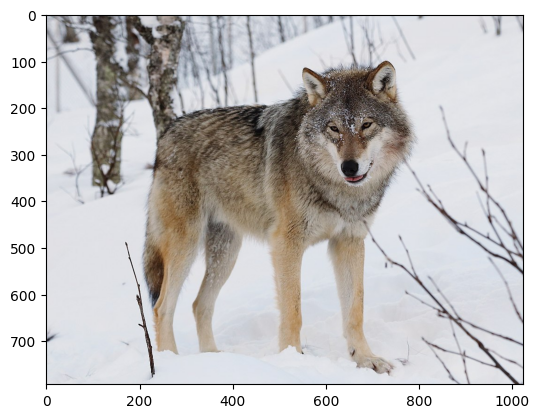

In [57]:
#Wybrany przykładowy obrazek
img = get_image("data/wolf.jpg")
plt.imshow(img)

In [58]:
from torchvision.models import resnet50, ResNet50_Weights

#Wybrane dwa modele resnet i densenet
resnet50_model = models.resnet50(pretrained=True)
densenet201_model = models.densenet201(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [59]:
print("resnet50")
get_prediction_probabilities(img, resnet50_model)
print()
print("densenet201")
get_prediction_probabilities(img, densenet201_model)

resnet50
Class: timber_wolf                    | Probability: 0.807128
Class: coyote                         | Probability: 0.092099
Class: red_wolf                       | Probability: 0.082850
Class: dingo                          | Probability: 0.008127
Class: white_wolf                     | Probability: 0.005670
Class: Eskimo_dog                     | Probability: 0.001936
Class: dhole                          | Probability: 0.000662
Class: Siberian_husky                 | Probability: 0.000422
Class: malamute                       | Probability: 0.000248
Class: dogsled                        | Probability: 0.000247
Class: grey_fox                       | Probability: 0.000163
Class: Norwegian_elkhound             | Probability: 0.000121
Class: German_shepherd                | Probability: 0.000081
Class: kelpie                         | Probability: 0.000015
Class: Tibetan_mastiff                | Probability: 0.000013

densenet201
Class: timber_wolf                    | Probabil

In [60]:
img_explanation_resnet = explainer.explain_instance(
    image=lime_transformer(img),
    classifier_fn=partial(predict_batch, resnet50_model),
    top_labels=5,
    num_samples=1000)

img_explanation_densenet = explainer.explain_instance(
    image=lime_transformer(img),
    classifier_fn=partial(predict_batch, densenet201_model),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

RESNET EXPLANATION


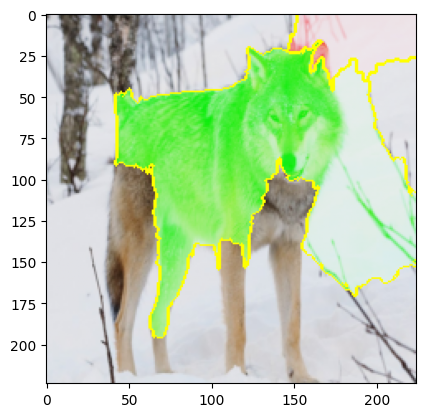

In [61]:
image, mask = img_explanation_resnet.get_image_and_mask(
    label=img_explanation_resnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
print("RESNET EXPLANATION")
plt.imshow(boundaries)




DENSENET EXPLANATION


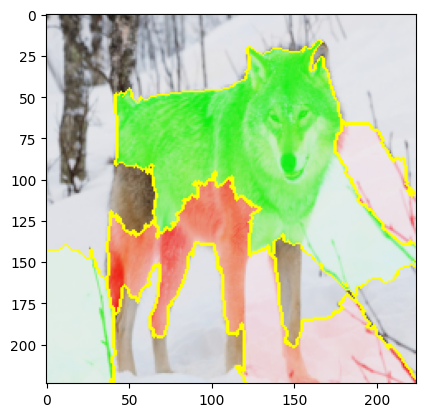

In [62]:
image, mask = img_explanation_densenet.get_image_and_mask(
    label=img_explanation_densenet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=15,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
print("DENSENET EXPLANATION")
plt.imshow(boundaries)

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

Area that will be cropped out


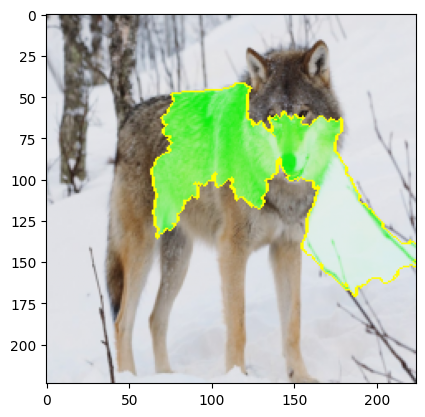

In [63]:
# Zadanie wykonam na przykładzie jednego z modeli - resnet

# Wizualizacja obszaru do zaciemnienia
image, mask = img_explanation_resnet.get_image_and_mask(
    label=img_explanation_resnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=3,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
print("Area that will be cropped out")
plt.imshow(boundaries)

In [64]:
mask.shape


(224, 224)

In [65]:
img_arr = np.array(img)
img_arr.shape

(793, 1024, 3)

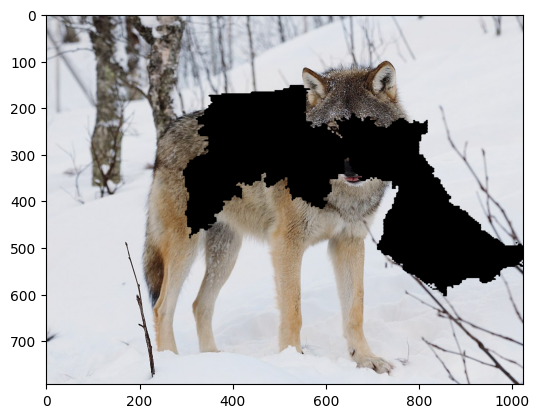

In [66]:
import cv2

# Resize the mask to match the image dimensions (793, 1024)
# Ensure mask is of type uint8 and values are within 0-255
resized_mask = cv2.resize(mask.astype(np.uint8), (img_arr.shape[1], img_arr.shape[0]))

# Make a 3-channel version of the mask to match the image channels
resized_mask_3d = np.stack([resized_mask] * 3, axis=-1)

# Set pixels where the mask is 1 to black in the image
img_cropped = img_arr.copy() # Create a copy to avoid modifying the original image

# Iterate through each channel (R, G, B) and apply the mask
for i in range(3):
    img_cropped[resized_mask_3d[:,:,i] == 1, i] = 0  # Assign 0 to the corresponding channel where the mask is 1

plt.imshow(img_cropped)

In [67]:
# Predykcja na obrazie z obszarem zaciemnionym
print("resnet50")
get_prediction_probabilities(Image.fromarray(img_cropped), resnet50_model)

resnet50
Class: coyote                         | Probability: 0.487675
Class: timber_wolf                    | Probability: 0.350002
Class: white_wolf                     | Probability: 0.104642
Class: red_wolf                       | Probability: 0.011500
Class: ostrich                        | Probability: 0.007979
Class: Eskimo_dog                     | Probability: 0.007542
Class: grey_fox                       | Probability: 0.004527
Class: dingo                          | Probability: 0.003431
Class: Siberian_husky                 | Probability: 0.003210
Class: dogsled                        | Probability: 0.002995
Class: lion                           | Probability: 0.002052
Class: German_shepherd                | Probability: 0.001990
Class: collie                         | Probability: 0.000886
Class: dhole                          | Probability: 0.000850
Class: ram                            | Probability: 0.000778


Wynik najbardziej prawdopodobnej klasy zmienił się z wilka (timber_wolf) na kojota. Obszar wyodrębniowy przez Lime jako istotny był zatem w istocie charakterystyczny w szególności dla wilka.

# Zadanie #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.

In [80]:
import random
import cv2

def add_noise(img):
    # Getting the dimensions of the RGB image
    row , col = img[:,:,0].shape

    for channel in range(3):
      # Randomly pick some pixels in the
      # image for coloring them white
      # Pick a random number between 300 and 10000
      number_of_pixels = random.randint(9000, 10000)
      for i in range(number_of_pixels):

          # Pick a random y coordinate
          y_coord=random.randint(0, row - 1)

          # Pick a random x coordinate
          x_coord=random.randint(0, col - 1)

          # Color that pixel to white
          img[y_coord][x_coord][channel] = 255

      # Randomly pick some pixels in
      # the image for coloring them black
      # Pick a random number between 300 and 10000
      number_of_pixels = random.randint(9000 , 10000)
      for i in range(number_of_pixels):

          # Pick a random y coordinate
          y_coord=random.randint(0, row - 1)

          # Pick a random x coordinate
          x_coord=random.randint(0, col - 1)

          # Color that pixel to black
          img[y_coord][x_coord][channel] = 0

    return img

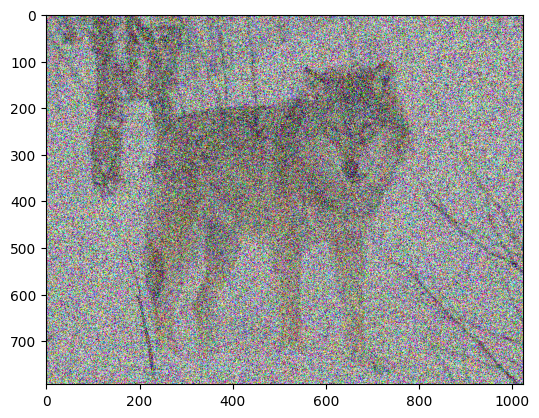

In [100]:
img_noisy = img
# applying the noise quite a few times for a good effect
for _ in range(50):
  img_noisy = Image.fromarray(add_noise(np.array(img_noisy)))


plt.imshow(img_noisy)

In [101]:
print("resnet50")
get_prediction_probabilities(img_noisy, resnet50_model)
print()
print("densenet201")
get_prediction_probabilities(img_noisy, densenet201_model)

resnet50
Class: Persian_cat                    | Probability: 0.370176
Class: coyote                         | Probability: 0.304053
Class: white_wolf                     | Probability: 0.091171
Class: timber_wolf                    | Probability: 0.049474
Class: lynx                           | Probability: 0.033317
Class: apron                          | Probability: 0.015406
Class: lion                           | Probability: 0.011998
Class: Norwich_terrier                | Probability: 0.011817
Class: trench_coat                    | Probability: 0.009855
Class: chow                           | Probability: 0.009094
Class: miniskirt                      | Probability: 0.008030
Class: tiger_cat                      | Probability: 0.005125
Class: tabby                          | Probability: 0.003142
Class: Samoyed                        | Probability: 0.002827
Class: window_screen                  | Probability: 0.002695

densenet201
Class: lynx                           | Probabil

  0%|          | 0/1000 [00:00<?, ?it/s]

RESNET EXPLANATION


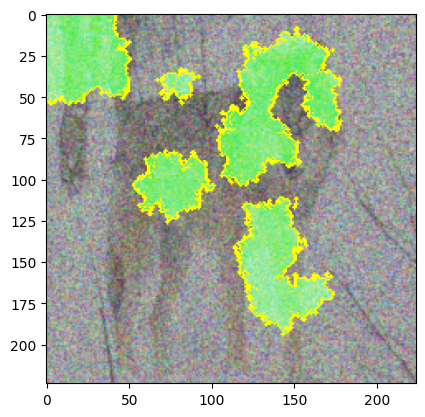

In [102]:
img_noisy_explanation_resnet = explainer.explain_instance(
    image=lime_transformer(img_noisy),
    classifier_fn=partial(predict_batch, resnet50_model),
    top_labels=5,
    num_samples=1000)


image, mask = img_noisy_explanation_resnet.get_image_and_mask(
    label=img_noisy_explanation_resnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
print("RESNET EXPLANATION")
plt.imshow(boundaries)

  0%|          | 0/1000 [00:00<?, ?it/s]

DENSENET EXPLANATION


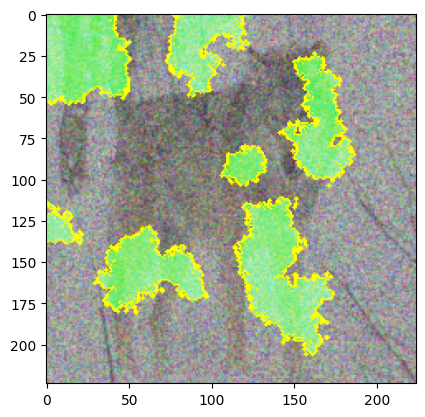

In [103]:
img_noisy_explanation_densenet = explainer.explain_instance(
    image=lime_transformer(img_noisy),
    classifier_fn=partial(predict_batch, resnet50_model),
    top_labels=5,
    num_samples=1000)


image, mask = img_noisy_explanation_densenet.get_image_and_mask(
    label=img_noisy_explanation_densenet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
print("DENSENET EXPLANATION")
plt.imshow(boundaries)

Oba modele zaproponowały etykietę wilka dopiero na 3 i 4 miejscu dla zaszumionego obrazu. Pojawiło się wiele klas opisujących koty zamiast psów (lynx, cougar, Persian_cat). Patrząc na wyjaśnienie LIME, można interpretować zaznaczone obszary jako podobne dla kotów i psów -> uszy, łapy.